# Count distribution in scRNA-seq data

We examine the marginal distribution of UMI counts in the raw single-nucleus RNA-seq data downloaded from http://resource.psychencode.org/. This count data is UMI-based, merged from two sources [Lake et al. (2018)](https://www.nature.com/articles/nbt.4038) and [Wang et al. (2018)](https://science.sciencemag.org/content/362/6420/eaat8464).

### Download data

In [1]:
rm(list = ls())
options(stringsAsFactors = FALSE)

suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(data.table)))
library(parallel)
detectCores()  # 16 cores

system("curl http://adult.psychencode.org/Datasets/Derived/SC_Decomp/DER-22_Single_cell_expression_raw_UMI.tsv --output DER-22_Single_cell_expression_raw_UMI.tsv")

[1] 16

### Load and munge data

In [2]:
lake_expr <- read.table("DER-22_Single_cell_expression_raw_UMI.tsv", sep = "\t")  # 17176 genes, 27412 cells

lake_annot <- data.frame("cell_id" = colnames(lake_expr))
lake_annot$level2class <- gsub("\\..*","", lake_annot$cell_id)
lake_annot$level1class <- lake_annot$level2class
lake_annot$level1class[grep("Ex", lake_annot$level1class)] <- "ExcNeu"
lake_annot$level1class[grep("In", lake_annot$level1class)] <- "InNeu"

idx <- which(lake_annot$level1class == "NA")
lake_annot <- lake_annot[-idx, ]
lake_expr <- lake_expr[, -idx]  # 17176 genes, 27380 cells

### Define function that estimates mean and variance

In [3]:
EstimateStat <- function(i, dataset, annot) {
  df <- tibble(UMI = t(dataset[i, ]),
               level1class = annot$level1class,
               gene = rownames(dataset)[i]) %>%
    group_by(level1class) %>% 
    summarize(mean = mean(UMI), 
              variance = var(UMI),
              zeros = sum(UMI == 0) / n(),
              .groups = "drop") %>% 
    mutate(gene = rownames(dataset)[i])
  return(df)
}

### Estimate mean and variance per gene and cell-type

In [4]:
df_adult <- do.call("bind_rows", mclapply(1:nrow(lake_expr), 
                                          EstimateStat, 
                                          dataset = lake_expr, 
                                          annot = lake_annot,
                                          mc.cores = 12))

write.table(df_adult, file = "adult-mean-variance.tsv", 
            quote = FALSE, row.names = FALSE, sep = "\t")

### Plot the relationship between mean and variance

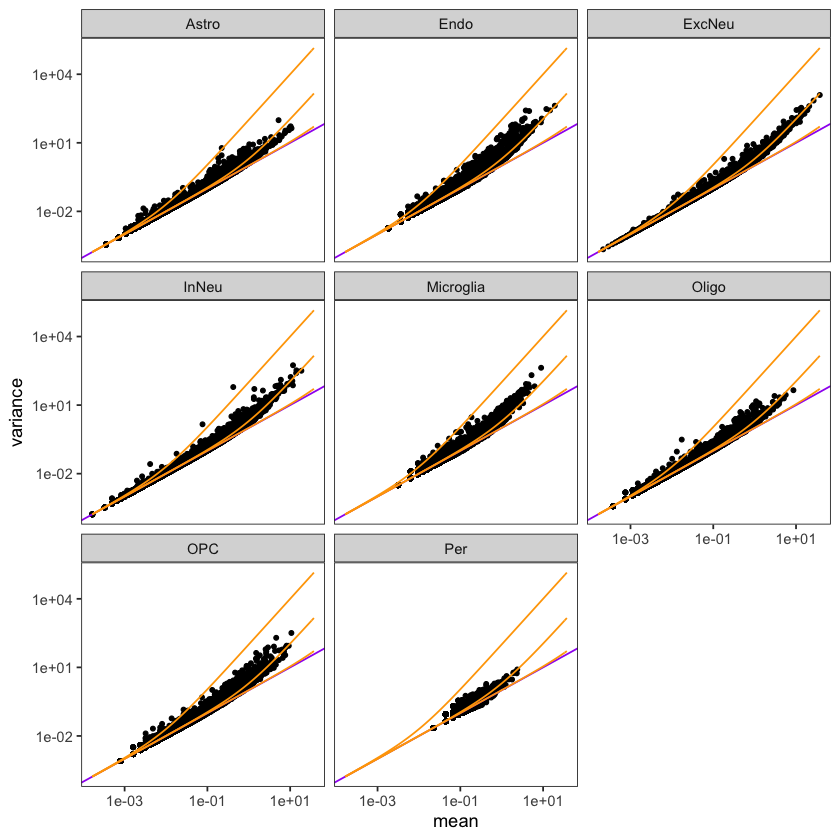

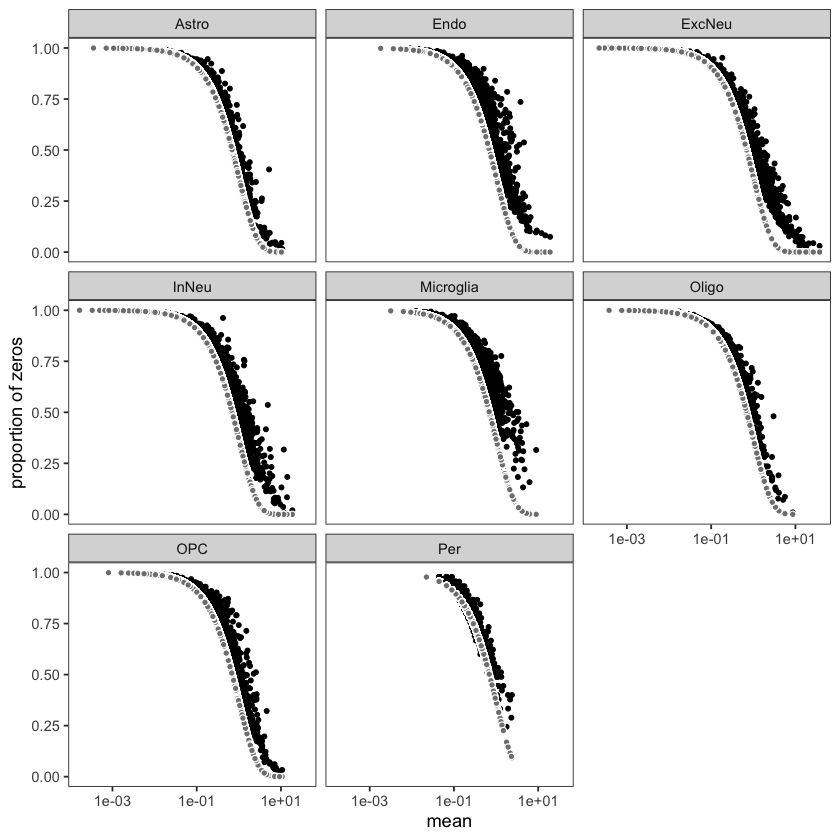

In [5]:
df_adult <- read.table("adult-mean-variance.tsv", header = TRUE)

df_adult %>% 
  filter(mean > 0) %>% 
  ggplot(aes(mean, variance)) +
  geom_point(size = 1) + 
  facet_wrap(level1class ~ .) +
  geom_abline(slope = 1, color = "purple") + 
  geom_function(fun = function(x) x + 0.01 * x^2, color = "orange") + 
  geom_function(fun = function(x) x + x^2, color = "orange") +
  geom_function(fun = function(x) x + 100 * x^2, color = "orange") +
  theme_bw() + 
  scale_x_log10() + 
  scale_y_log10() + 
  theme(panel.grid = element_blank())

df_adult %>% 
  filter(mean > 0) %>% 
  mutate(expected = exp(-mean)) %>% 
  ggplot(aes(mean , zeros)) +
  geom_point(size = 1) + 
  geom_point(aes(mean, expected), fill = "grey50", color = "white", size = 1.5, pch = 21) + 
  facet_wrap(level1class ~ .) +
  scale_x_log10() + 
  theme_bw() + ylab("proportion of zeros") + 
  theme(panel.grid = element_blank())

In theory, UMI counts per cell-type could be modeled as a Poisson distribution, if we assume that cells within the same cell-type are essentially technical replicates with minimal biological variability. However, most genes deviate significantly from the purple, identity line and instead lie closer to $\text{Var} = \mu + \phi \mu^2$, where $\phi = 1$. The other orange lines represent $\phi = 100$ and $0.01$. The proportion of cells with zero counts is also consistenly higher than the expected fraction shown in grey, again suggesting the inadequate fit of the Poisson distribution. 

Such an overdispersion could be due to multiple factors. First, there exists known cell subtype heterogeneity which can introduce additional variability in gene expression. Stratifying the cells further could help account for increased variance. Here, we also do not account for differences in read depth across cells, and the cells are actually from $\geq 4$ different individuals, which can all introduce additional variability in UMI counts.

In [6]:
sessionInfo()

R version 4.0.1 (2020-06-06)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS  10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.0/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] data.table_1.13.4 forcats_0.5.0     stringr_1.4.0     dplyr_1.0.2      
 [5] purrr_0.3.4       readr_1.4.0       tidyr_1.1.2       tibble_3.0.4     
 [9] ggplot2_3.3.3     tidyverse_1.3.0  

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.3-4      tidyselect_1.1.0  repr_1.1.3        haven_2.3.1      
 [5] colorspace_2.0-0  vctrs_0.3.6       generics_0.1.0    htmltools_0.5.0  
 [9] base64enc_0.1-3   rlang_0.4.10      pillar_1.4.7      glue_1.4.2       
[13] withr_2.3.0       D